In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob
from tqdm import tqdm
import os

In [2]:
train_cat_path = glob.glob("./train/cat*")
train_dog_path = glob.glob("./train/dog*")

test_path = glob.glob("./test/*")

assert len(train_cat_path) == len(train_dog_path)

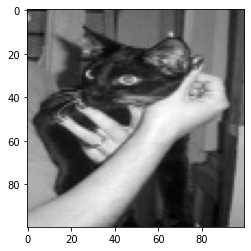

In [3]:
IMAGE_SIZE = 100
image = cv2.imread(train_cat_path[0])
resized_image = cv2.resize(image,(100,100))
grayscaled_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

plt.imshow(grayscaled_image,cmap='gray')
plt.show()

In [4]:
if not (os.path.exists('train.npy') and os.path.exists('train_label.npy')):
    train_cat = []
    train_dog = []
    label_cat = []
    label_dog = []

    for cat_path in tqdm(train_cat_path):
        image = cv2.imread(cat_path)
        resized_image = cv2.resize(image,(100,100))
        grayscaled_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        train_cat.append(grayscaled_image[np.newaxis,:,:])
        label_cat.append(0)

    for dog_path in tqdm(train_dog_path):
        image = cv2.imread(dog_path)
        resized_image = cv2.resize(image,(100,100))
        grayscaled_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        train_dog.append(grayscaled_image[np.newaxis,:,:])
        label_dog.append(1)

    train = train_cat + train_dog
    train_label = label_cat + label_dog

    np.save('train.npy',np.array(train).astype(np.float)/256)
    np.save('train_label.npy',np.array(train_label).astype(np.float))
else:
    train = list(np.load('train.npy'))
    train_label = list(np.load('train_label.npy'))
    
if not os.path.exists('test.npy'):
    test = []

    for path in tqdm(test_path):
        image = cv2.imread(path)
        resized_image = cv2.resize(image,(100,100))
        grayscaled_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        test.append(grayscaled_image[np.newaxis,:,:])

    np.save('test.npy',np.array(test).astype(np.float)/256)
else:
    test = list(np.load('test.npy'))

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [6]:
train = torch.Tensor(train)
train_label = torch.Tensor(train_label)

train_dataset = TensorDataset(train,train_label)
train_dataloader = DataLoader(train_dataset,batch_size=200,shuffle=True) # create your dataloader

test = torch.Tensor(test)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(7744,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,1)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,7744)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")

running on the GPU


In [9]:
net = Net().float().to(device)

In [10]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
BATCH_SIZE = 200
EPOCHS = 10

for epoch in range(EPOCHS):
    for i,data in enumerate(train_dataloader):

        batch_X,batch_y = data
        batch_X = batch_X.to(device)
        batch_y = batch_y.view(-1,1).to(device)
        
        #print(batch_y)
        net.zero_grad()
        outputs = net(batch_X)
        loss = criterion(outputs,batch_y)

        loss.backward()
        optimizer.step()

#         if i % 50 == 0:
#             val_acc,  val_loss = test(size=100)
#             f.write(f"{MODEL_NAME},{round(time.time(),3)},\
#                     {round(float(acc),2)},\
#                     {round(float(loss),4)},\
#                     {round(float(val_acc),2)},\
#                     {round(float(val_loss),4)}\n")
    print(f"Epochs: {epoch} train_loss: {loss}")

125it [00:05, 24.17it/s]
4it [00:00, 30.27it/s]

Epochs: 0 train_loss: 0.6922333240509033


125it [00:05, 24.44it/s]
4it [00:00, 30.60it/s]

Epochs: 1 train_loss: 0.6921071410179138


125it [00:05, 24.40it/s]
4it [00:00, 30.11it/s]

Epochs: 2 train_loss: 0.6914859414100647


125it [00:05, 24.38it/s]
4it [00:00, 29.75it/s]

Epochs: 3 train_loss: 0.6929384469985962


125it [00:05, 24.25it/s]
4it [00:00, 30.16it/s]

Epochs: 4 train_loss: 0.6919996738433838


125it [00:05, 24.12it/s]
4it [00:00, 29.38it/s]

Epochs: 5 train_loss: 0.6917864680290222


125it [00:05, 24.14it/s]
4it [00:00, 29.36it/s]

Epochs: 6 train_loss: 0.692543625831604


125it [00:05, 24.66it/s]
4it [00:00, 30.25it/s]

Epochs: 7 train_loss: 0.6901071071624756


125it [00:05, 24.52it/s]
4it [00:00, 30.02it/s]

Epochs: 8 train_loss: 0.6882357001304626


125it [00:05, 23.90it/s]


Epochs: 9 train_loss: 0.6903108954429626
